# Introduction
*how to build an auto-correct using a language model*

Example auto-correct: **aplle** -> **apple**

**Goal** 

Language models and how they work.

**Sections**:

- **Tokenizer:** how to process the word input to be ingested by the language model

- **Model training:** how to create and train a Transformer model 

- **Completions:** how to generate completions 

- **Auto-correct**: how to build a simple auto-correct 

# Tokenizer


**Theory**

A tokenizer has a vocabulary which is the set of all possible inputs that it can process.

`vocab = ["a", "b", "c"]`

Given an input, it generates the tokenized version as:

`Tokenizer(vocabulary=vocab).tokenize("aba")= [0, 1, 0]`

A tokenizer can have extra functionality, such as padding to a fixed length:

`vocab_pad = ["", "a", "b", "c"]`

After padding with fixed output length.

`Tokenizer(vocabulary=vocab_pad, length=5).tokenize("aba")= [1, 2, 1, 0, 0]`

**Practice**

In this section:

- we load a dataset of more than unique 200,000 words in english
- we find all letters (characters) used and create a vocabulary
- we build a tokenizer with padding and special characters 

Loading words in a list (lower-case).

Text file can be created using:

```
cat /usr/share/dict/words > ~/words.txt
```

then the text file can be uploaded to the notebook.

In [1]:
words_file = 'words.txt'
with open(words_file) as f:
    words = list(map(lambda x: x.lower(), f.read().split("\n")))
print(f"Number of unique words: {len(words)}")
max_characters = max([len(w) for w in words])
print(f"Longest word has {max_characters} characters.")


Number of unique words: 235887
Longest word has 24 characters.


Finding all unique characters. 

In [2]:
unique_characters = set()
for w in words:
  for c in w:
    unique_characters.add(c)
unique_characters = list(unique_characters)
unique_characters.sort()
print(f"Unique characters: {unique_characters}")

Unique characters: ['-', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


**Creating a tokenizer.**


We add 2 special characters to the vocabulary representing the beggining of a word (`":"`), and end of a word (`"."`).

2 more characters are added automatically:

- padding (index 0) so we can make all the words have the same length after padding
- `[UNK]` (index 1) if an input has a charcter not present in the vocabulary, it will be be replaced by the unkown token

We also set the fixed size after tokenizer to `max_characters + 3`. `max_characters` represents the longest word. 2 extra characters are needed for beginning and end of word and an extra one to deal if causality (explained later).

In [3]:
from keras.layers import TextVectorization
tokenizer = TextVectorization(split="character", 
                              vocabulary=unique_characters+[':','.'], 
                              output_sequence_length=max_characters+3,
                              standardize=None)

In [4]:
print(f"Vocabulary and corresponding integers: \n{[(i,v) for i,v in enumerate(tokenizer.get_vocabulary())]}\n")
tokenized_word = tokenizer(":apple.")
print(f"\"apple\" after tokenization and inclusion of beginnining and end of word tokens: \n{tokenized_word}")

Vocabulary and corresponding integers: 
[(0, ''), (1, '[UNK]'), (2, '-'), (3, 'a'), (4, 'b'), (5, 'c'), (6, 'd'), (7, 'e'), (8, 'f'), (9, 'g'), (10, 'h'), (11, 'i'), (12, 'j'), (13, 'k'), (14, 'l'), (15, 'm'), (16, 'n'), (17, 'o'), (18, 'p'), (19, 'q'), (20, 'r'), (21, 's'), (22, 't'), (23, 'u'), (24, 'v'), (25, 'w'), (26, 'x'), (27, 'y'), (28, 'z'), (29, ':'), (30, '.')]

"apple" after tokenization and inclusion of beginnining and end of word tokens: 
[29  3 18 18 14  7 30  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0]


# Model training

**Theory**

We use a Transformer model which has a simplified interface:

`output = transformer(tokenized_input)`

The input is a fixed length (`N`) array of integers from 0 to `vocab_size-1` such as:

`input = "bcba", N = 4, vocab_size = 3, tokenized_input = [1, 2, 1, 0]`

The output has shape `N`x`vocab_size`:

`output = [[0.0, 0.5, 0.5],`

`[0.3, 0.3, 0.4],`

`[0.6, 0.2, 0.2],`

`[0.1, 0.2, 0.7]]`

The output is a conditional probability (of generating a given next character given previous characters):





`output[0][0] = `$p(\text{next character="a"}|\text{previous characters="b"})$

`output[0][1] = `$p(\text{next character="b"}|\text{previous characters="b"})$

`output[0][2] = `$p(\text{next character="c"}|\text{previous characters="b"})$

`output[1][0] = `$p(\text{next character="a"}|\text{previous characters="bc"})$

...



If we want our model to generate `"bcba"` with higher probability, we need to maximize the following probabilities:

$p(\text{next character="c"}|\text{previous characters="b"})$,

$p(\text{next character="b"}|\text{previous characters="bc"})$ and

$p(\text{next character="a"}|\text{previous characters="bcb"})$

So training a model is basically changing the model's *parameters* in the direction of predciting the correct targets for the input examples we care.

**Practice**

Some additional thigs are needed:

1. End of word token (`"."`): our model needs to know when to stop generating a word
2. Beginning of word token (`":"`): so our model can predict the probability of the first character of the word (unconditional probability)
3. Batches and fixed size: to process many words at the same time (in batches), we need to force them to have the same length so we add padding
4. The next character targets are simply the input word shifted left
5. We maximize the probability of generating the correct targets by *minimizing the cross-entropy between the model outputs and the targets* averaged over the whole dataset (loss)



**Defining the model**

Here we use a decoder-only transformer model (details of the model are not very important).

The signature of the model is as follows:

Inputs have sizes `[batch_size, word_length]` . In our case word length is `max_characters+2` and `batch_size` is the number of words we want to process in parallel at the same time.

Outputs have sizes `[batch_size, word_length, vocab_size]`. For each character we output the probability of the next character being the characters in the vocabulary.

`mask_zero` is important to ignore the padding (0s).


In [5]:
!pip install -q git+https://github.com/keras-team/keras-nlp.git --upgrade
import keras_nlp
from tensorflow import keras

def get_model():
  decoder_inputs = keras.Input(shape=(None,), dtype="int64")

  token_position_embedding = keras_nlp.layers.TokenAndPositionEmbedding(
      vocabulary_size=len(tokenizer.get_vocabulary()),
      sequence_length=max_characters+2,
      embedding_dim=64,
      mask_zero=True,
  )(decoder_inputs)

  decoder = keras_nlp.layers.TransformerDecoder(
      intermediate_dim=64, num_heads=8)(token_position_embedding)
  
  decoder_outputs = keras.layers.Dense(
      len(tokenizer.get_vocabulary()),
      activation="softmax")(decoder)

  model = keras.Model(decoder_inputs, decoder_outputs)
  return model
model = get_model()

  Preparing metadata (setup.py) ... done


**Creating the dataset to train the model**

We basically add `":"` at the beggining of word and `"."` at the end for each word. Then we tokenize. Since what we are predicting is the next character, the target is simply the input shifted by one element (that is why we increased the tokenizer output size by one).

We then shuffle the words and create batches to be processed in parallel.

In [6]:
import tensorflow as tf

def preprocess(example):
  tokenized = tokenizer(":"+example+".")
  return tokenized[:-1], tokenized[1:] #input, target (shift by 1)

BATCH_SIZE=512
dataset = tf.data.Dataset.from_tensor_slices(words)
dataset = dataset.shuffle(len(words))
dataset = dataset.map(preprocess)
train_ds = dataset.batch(BATCH_SIZE)
eval_ds = dataset.take(int(len(words)*0.1)).batch(BATCH_SIZE)


In [7]:
for i in train_ds:
  print(f"Input shape: {i[0].shape}")
  print(f"Output shape: {model(i[0]).shape}")
  print(f"Example input: {i[0][0]}")
  print(f"Example target (shifted by one): {i[1][0]}")
  break

Input shape: (512, 26)
Output shape: (512, 26, 31)
Example input: [29  5  3 16 11 21 11  3 16  3 30  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0]
Example target (shifted by one): [ 5  3 16 11 21 11  3 16  3 30  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0]


**Training the model**

Metrics:

- Accuracy: the percentage of predictions that correspond to the correct token. Note that it cannot be 100% for this problem, since predicting the first character of a word is impossible (the best you can do is predicting the most frequent first letter in the dataset).

- Loss: cross-entropy, the closer to 0 the better. Basically -log(probability of the correct character). If you predict 1 for the correct character, loss for this character is 0. As you predict close to 0 for the correct character, loss goes to infinity (bad).

Training corresponds to the process of changing the parameters of the model to minimize the loss (via stochastic gradient descent). At every batch of examples, we calculate a small step in the parameters of the model that reduces the loss for those examples. By seing all examples many times (10 times each: number of epochs) and doing many small steps, accuracy increases and loss decreases.

In [8]:
model.compile(
    "adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)
model.fit(train_ds, epochs=10, validation_data=eval_ds)

Epoch 1/10
461/461 [==============================] - 173s 366ms/step - loss: 2.2534 - accuracy: 0.2997 - val_loss: 2.1067 - val_accuracy: 0.3307
Epoch 2/10
461/461 [==============================] - 138s 299ms/step - loss: 2.0537 - accuracy: 0.3475 - val_loss: 2.0069 - val_accuracy: 0.3624
Epoch 3/10
461/461 [==============================] - 146s 315ms/step - loss: 1.9840 - accuracy: 0.3705 - val_loss: 1.9643 - val_accuracy: 0.3783
Epoch 4/10
461/461 [==============================] - 140s 304ms/step - loss: 1.9500 - accuracy: 0.3824 - val_loss: 1.9368 - val_accuracy: 0.3863
Epoch 5/10
461/461 [==============================] - 137s 297ms/step - loss: 1.9297 - accuracy: 0.3885 - val_loss: 1.9180 - val_accuracy: 0.3925
Epoch 6/10
461/461 [==============================] - 149s 323ms/step - loss: 1.9156 - accuracy: 0.3929 - val_loss: 1.9071 - val_accuracy: 0.3955
Epoch 7/10
461/461 [==============================] - 134s 289ms/step - loss: 1.9052 - accuracy: 0.3961 - val_loss: 1.8986 -

In [9]:
#@title Plotting helper function
def plot_probs(word, word_prediction):
  import numpy as np
  import matplotlib.pyplot as plt

  # Generate a 2D table of probabilities
  probs = np.transpose(word_prediction[0,:len(word)+1])

  # Set the colormap to go from red to green
  cmap = plt.cm.get_cmap('RdYlGn')

  # Plot the table
  fig, ax = plt.subplots()
  fig.set_size_inches(20, 12) 
  im = ax.imshow(probs, cmap=cmap, vmin=0, vmax=0.5)

  # Set the axis labels and title
  ax.set_xlabel('Context')
  ax.set_ylabel('Probability')
  ax.set_title('Probabilities given current context')

  # Add a colorbar to show the probability scale
  cbar = ax.figure.colorbar(im, ax=ax)
  cbar.ax.set_ylabel('Probability', rotation=-90, va="bottom")
  ax.set_yticks(np.arange(len(tokenizer.get_vocabulary())))
  ax.set_yticklabels(tokenizer.get_vocabulary())
  ax.set_xticks(np.arange(len(word)+1))
  ax.set_xticklabels([c for c in ":"+word])
  # Show the plot
  plt.show()


**Example**

Seeing probabilities for an untrained model.

`word = "influent"`

We see that probabilities of the correct targets are very low (<0.1).

In [44]:
word = "suspense"
untrained_model = get_model()
tokenized_word = tokenizer([":"+word+"."])[:,:-1]
word_prediction = untrained_model(tokenized_word).numpy()
for i, c in enumerate(word+'.'):
  index = tokenizer.get_vocabulary().index(c)
  prob = word_prediction[0,i,index]
  print(c, prob)

s 0.017268935
u 0.024576787
s 0.01612967
p 0.0013490865
e 0.0036055818
n 0.007735257
s 0.040517386
e 0.009269094
. 0.012285344


<ipython-input-9-af3df61d9925>:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('RdYlGn')


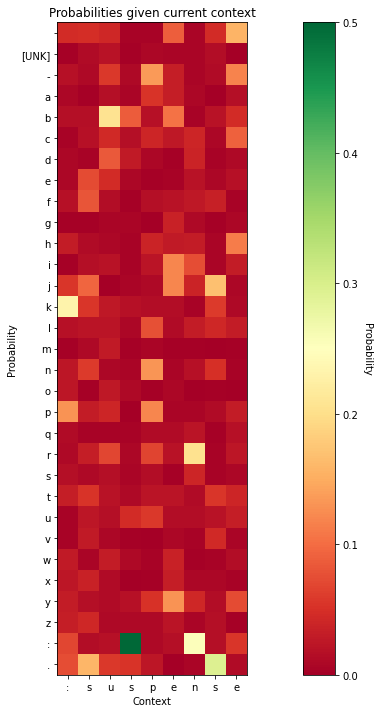

In [45]:
plot_probs(word, word_prediction)

**After training**

Many probabilities are now >0.1

In [46]:
word_prediction_trained = model(tokenized_word).numpy()
for i, c in enumerate(word+'.'):
  index = tokenizer.get_vocabulary().index(c)
  prob = word_prediction_trained[0,i,index]
  print(c, prob)

s 0.109861694
u 0.1765371
s 0.012084289
p 0.11174494
e 0.45606142
n 0.15477082
s 0.13514712
e 0.17323653
. 0.20991006


<ipython-input-9-af3df61d9925>:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('RdYlGn')


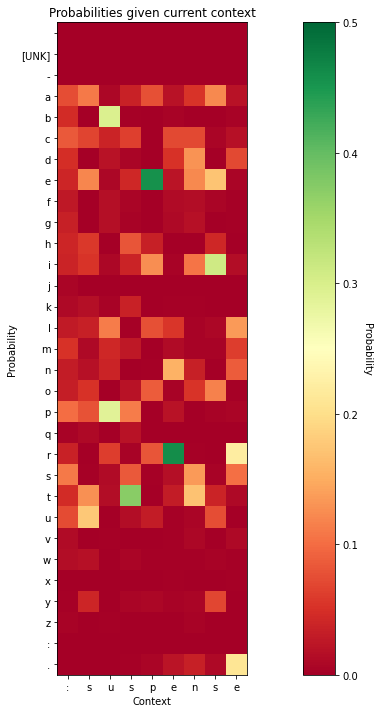

In [47]:
plot_probs(word, word_prediction_trained)

# Completion

**Practice**

If we have a model that can generate good conditional probabilities:

$p(\text{next character}|\text{previous characters})$

we can use it to generate completion suggestions. For example, if the user types `influen`, we pick the next character as  one with the highest probability:

$\text{next_token} = \text{argmax}_c p(\text{next character}=c|\text{previous characters}=\text{":influen"})$

Now that we have the next token, we can call the model again with an updated input (including new character) and keep generating until we get the end of work token `"."`. This is called **greedy decoding** and it is deterministic.

Sometimes, we want to diversify the generations, one way to do this is sample the next character from a distribution defined by the model probabilities instead doing greedy decoding .

Example: 

$p(\text{next character}|\text{previous characters}=\text{":ca"})$ = `[("t", 0.9), ("r", 0.1), ("a", 0.0), ...]`

**Greedy**: we always pick `"t"` 

**Sampling**: we pick `"t"` 90% of times and `"r"` 10% of times

**Sampling with temperature**: when temperature is `1.0`, it works as usual sampling. As temperature goes to `0.0`, it behaves more like greedy. As temperature goes to `Inf`, it behaves a a uniform sampler (all characters have same probability of being pick).

Seeing next character proabilities

In [53]:
import numpy as np
prefix = "suspens"
tokenized_word = tokenizer([":"+prefix+"."])[:,:-1]
prefix_prediction = model(tokenized_word)
next_character_pmf = prefix_prediction[0,len(prefix),:].numpy()
top_characters = np.argsort(-next_character_pmf)[:5]
print(f"For prefix \"{prefix}\", the top 5 next character predictions are:\n")
print("Probability","Next charcater")
for i in top_characters:
  print(next_character_pmf[i],tokenizer.get_vocabulary()[i])

For prefix "suspens", the top 5 next character predictions are:

Probability Next charcater
0.30870304 i
0.17323653 e
0.121764004 a
0.11564232 o
0.07562093 u


**Implementing greedy decoding**

and generating greedy completion.

In [18]:
def greedy_completion(prefix):
  tokenized_word = tokenizer([":"+prefix+"."])[:,:-1]
  prefix_prediction = model(tokenized_word)
  next_character_pmf = prefix_prediction[0,len(prefix),:].numpy()
  return tokenizer.get_vocabulary()[np.argmax(next_character_pmf)]

In [42]:
#greedy
completion = ""
next_character =""
while next_character != '.':
  print(prefix+completion)
  next_character = greedy_completion(prefix+completion)
  completion = completion + next_character



suspens
suspensi
suspensio
suspension


**Implementing random decoding**

and generating 5 completions.

In [20]:
def noisy_completion(prefix, T=1):
  tokenized_word = tokenizer([":"+prefix+"."])[:,:-1]
  prefix_prediction = model(tokenized_word)
  next_character_pmf = list(prefix_prediction[0,len(prefix),:].numpy())
  next_character_pmf = [np.exp(np.log(p)/T) for p in next_character_pmf]
  next_character_pmf = [p/sum(next_character_pmf) for p in next_character_pmf]
  sampled_caracter = np.argmax(np.random.multinomial(1, next_character_pmf))
  return tokenizer.get_vocabulary()[sampled_caracter]

In [43]:
# with sampling
for _ in range(5):
  completion = ""
  next_character =""
  while next_character != '.':
    print(prefix+completion)
    next_character = noisy_completion(prefix+completion, T=0.5)
    completion = completion + next_character
  print("")

suspens
suspensi
suspensio
suspension

suspens
suspensi
suspensiv
suspensive

suspens
suspense

suspens
suspensi
suspensiv
suspensive
suspensivel
suspensively

suspens
suspenso
suspenson
suspensoni
suspensonia
suspensonian



# Auto-correct

**Theory**

**Calculating word probability (likelihood) from characters's conditional probabilities**

With the model trained, we can now make predictions for different words.

Model inputs

":apple."

Model outputs


- $p(c_1) $
- $p(c_2|\text{input}=\text{"a"})$
- $p(c_3|\text{input}=\text{"ap"})$
- $p(c_4|\text{input}=\text{"app"})$
- $p(c_4|\text{input}=\text{"appl"})$
- ...

$p(\text{"apple."}) \approx \prod p(c_1=\text{"a"}) p(c_2=\text{"p"}|\text{input}=\text{"a"})p(c_3=\text{"p"}|\text{input}=\text{"ap"})...$

$\log(p(\text{"apple."})) \approx \sum \log(p(c_1=\text{"a"})) \log(p(c_2=\text{"p"}|\text{input}=\text{"a"})) \log(p(c_3=\text{"p"}|\text{input}=\text{"ap"}))...$

So we can calculate the log-likelihood of a given word and see if it has higher likelihood compared to others (the higher the better).

**Practice**

Using the word likelihood, we can score words. We can simulate character flipping (ex: `spple` to `apple`). And see if the new word has higher likelihood. If we find a high likelihood word, we can suggest to the user as a more probable correct spelling.

Calculating word log-likelihood.

In [22]:
import math
def get_word_log_likelihood(word):
  tokenized_word = tokenizer([":"+word+"."])[:,:-1]
  word_prediction = model(tokenized_word)
  characters_probabilities = [word_prediction[0,i,tokenizer.get_vocabulary().index(c)].numpy() for i, c in enumerate(word+'.')]
  return sum([math.log(p) for p in characters_probabilities])/len(word) #normalize to word length


Test with different corruptions.

In [23]:
for w, comment in [("apple", "correct spelling"), ("aplle", "substitution"), ("applye", "insertion"), ("aple","deletion")]:
  print(f"The length-normalized log-likelihood of {w} ({comment}) is {get_word_log_likelihood(w)}")


The length-normalized log-likelihood of apple (correct spelling) is -2.7263827409474652
The length-normalized log-likelihood of aplle (substitution) is -4.06571227163934
The length-normalized log-likelihood of applye (insertion) is -3.209841080072183
The length-normalized log-likelihood of aple (deletion) is -3.6735034551443597


**Autocorrect substitutions**

For a given word, calculates the log-likelihood. Try all possible single substitutions (replace first letter to all possible ones, then second, then third...). Get the word with higher likelihood, if it is different than the original, it can be proposed as the correct spelling.

In [48]:
def auto_correct(word):
  words_log_likelihoods = []
  for i in range(len(word)):
    for c in unique_characters:
      if c!=word[i]:
        new_word = word[:i]+c+word[i+1:] # substitution
        words_log_likelihoods.append([get_word_log_likelihood(new_word), new_word])
  words_log_likelihoods.append([get_word_log_likelihood(word), word])
  words_log_likelihoods.sort(key=lambda x: x[0], reverse=True)
  return words_log_likelihoods

word = "aplle"
print(f"Suggesting 5 spellings for {word}")
auto_correct(word)[:5] # take best 5

Suggesting 5 spellings for aplle


[[-2.7263827409474652, 'apple'],
 [-2.889606066538758, 'aulle'],
 [-2.892753246144773, 'apole'],
 [-2.913354235767755, 'apile'],
 [-2.9263234224159076, 'aille']]

In [50]:
word = "disasrer"
print(f"Suggesting 5 spellings for {word}")
auto_correct(word)[:5] # take best 5

Suggesting 5 spellings for disasrer


[[-1.9436105223947586, 'disaster'],
 [-2.1585220267685883, 'disasper'],
 [-2.1720079632863243, 'disasser'],
 [-2.224824480963634, 'disaurer'],
 [-2.231815737666708, 'disascer']]